In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [11]:
from google.colab import files
uploaded = files.upload()

Saving test data.xls to test data.xls


In [3]:
train_df = pd.read_csv('/content/training data.xls',
                       parse_dates = ['Week Start Date'],
                       index_col = ['Week Start Date'])

train_df = train_df.drop(['Product Name'], axis = 1)
train_df.head()

,Weekly Demand Quantity
Week Start Date,
2018-07-07,3198
2018-07-14,12181
2018-07-21,13494
2018-07-28,17963
2018-08-04,11009


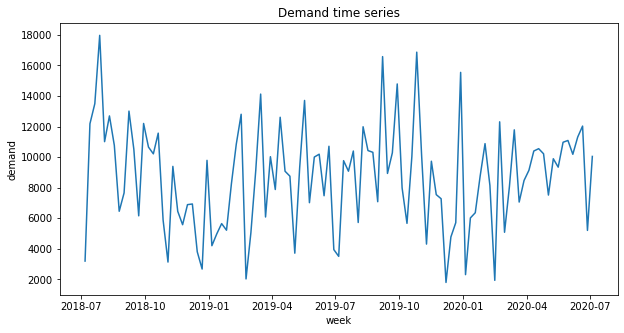

In [4]:
plt.figure(figsize=(10,5))
plt.xlabel('week')
plt.ylabel('demand')
plt.title('Demand time series')
plt.plot(train_df)
plt.show()

In [5]:
#lets seperate trend, seasonality and residue

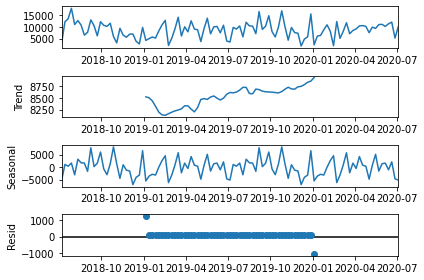

In [6]:
series = train_df[['Weekly Demand Quantity']]
result = seasonal_decompose(series, model = 'additive' )
result.plot()
plt.show()

In [8]:
#we will use pmdarima library for using arima model
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 14.5 MB/s 
     |████████████████████████████████| 9.5 MB 54.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
from pmdarima import auto_arima

In [8]:
#fitting the arima model
model = auto_arima(train_df['Weekly Demand Quantity'], ,trace = True)
model.fit(train_df['Weekly Demand Quantity'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2017.050, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2009.893, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2010.772, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2011.102, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2220.018, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2013.227, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.613 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [9]:
#forecasting for 8 weeks
forecast = model.predict( n_periods= 8)
forecast = pd.DataFrame(forecast, columns = ['Prediction'], index= pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT' ))

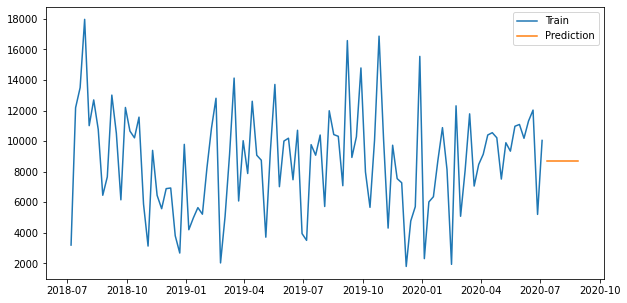

In [10]:
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'Train')
plt.plot(forecast, label = 'Prediction')
plt.legend()
#plt.show()

In [12]:
#importing test data
test_df = pd.read_csv('/content/test data.xls',
                      parse_dates = ['Week Start Date'],
                       index_col = ['Week Start Date'])

test_df = test_df.drop(['Product Name'], axis = 1)
test_df

,Weekly Demand Quantity
Week Start Date,
2020-07-11,5502
2020-07-18,11564
2020-07-25,17374
2020-08-01,8520
2020-08-08,6015
2020-08-15,11287
2020-08-22,12076
2020-08-29,6304


In [13]:
actual_data = np.array(test_df)
forecasted = np.array(forecast)

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def WMAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return (np.sum(np.abs((y_true - y_pred))) / np.sum(y_true)) * 100

In [15]:
mape = mean_absolute_percentage_error(actual_data,forecasted)
print('MAPE',mape)
wmape = WMAPE(actual_data,forecasted)
print('WMAPE',wmape)

MAPE 33.584348925956455
WMAPE 33.01035070318659


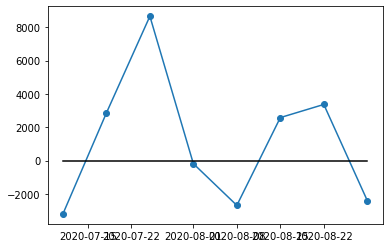

In [16]:
#Residual analysis
plt.scatter(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT' ),actual_data - forecasted )
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT' ),actual_data - forecasted )
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT' ),8*[0], color = 'k')

Note before fitting the model it is important to make time series stationary. So lets check rolling mean and rolling variance to see the stationarity.

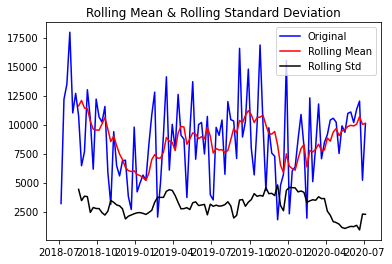

In [17]:
df = train_df
rolling_mean = df.rolling(window = 7).mean()
rolling_std = df.rolling(window = 7).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

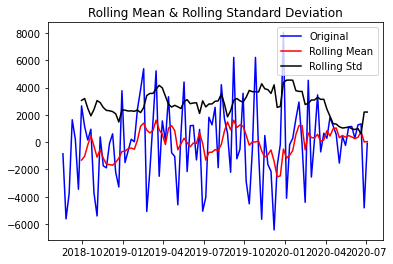

In [18]:
rolling_mean = df.rolling(window=7).mean()
df_minus_mean = df - rolling_mean
df_minus_mean.dropna(inplace=True)

df = df_minus_mean
rolling_mean = df.rolling(window = 7).mean()
rolling_std = df.rolling(window = 7).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

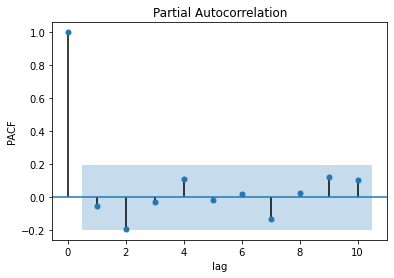

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
series = df_minus_mean
plot_pacf(series, lags = 10)
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

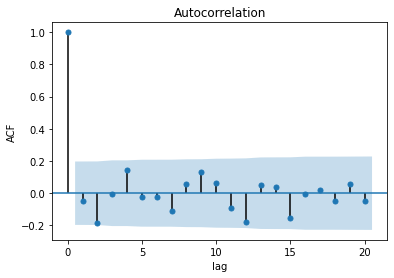

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
series = df_minus_mean
plot_acf(series)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()

ACF stands for AutoCorrelationFunction

ACF plot at lag k shows the correlation between the time series observstion seperated by k periods.

So we can take AR order (Autoregression order) to be k for which correlation is high i.e. for that  k for which value lie outside the CI in the ACF plot.

Similary PACF is used to decide MA order for ARIMA model.

Note the blue region is 95% CI and vertical lines which cross this region are considered significant.

So we will take 2 as AR order and MA order for our ARIMA model.

Now we will apply ARIMA model to this time series.

In [21]:
AR_order = 2
differencing_order = 0
MA_order = 2
order = (AR_order, differencing_order, MA_order)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be

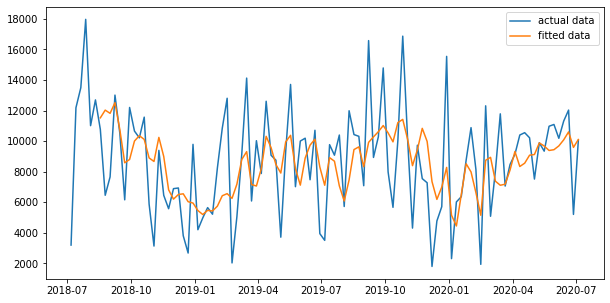

In [22]:
model = ARIMA(df, order= order,)
results = model.fit()

a = np.array(results.fittedvalues).reshape(1,-1)
rolling_mean = train_df.rolling(window=7).mean()
b = np.array(rolling_mean).reshape(1,-1)
#b = 8707.24761905*np.ones(shape=(1,len(a)))
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'actual data')
plt.plot(pd.date_range('2018-08-18',periods = 99, freq = 'W-SAT'),sum(a,b[0,6:]).reshape(-1,1), label = 'fitted data')
plt.legend()
plt.show()

In [23]:
rolling_mean = train_df.rolling(window=7).mean()
rolling_mean = rolling_mean[6:][:]
model = ARIMA(rolling_mean, order= order)
results_for_mean = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be

In [24]:
results_for_mean.predict(99,106)

2020-07-11    10069.561446
2020-07-18     9971.537510
2020-07-25     9895.487531
2020-08-01     9825.736157
2020-08-08     9761.662196
2020-08-15     9702.802756
2020-08-22     9648.733459
2020-08-29     9599.064468
Freq: W-SAT, dtype: float64

In [25]:
results.predict(99,106)

2020-07-11    621.591974
2020-07-18    119.194617
2020-07-25   -644.882582
2020-08-01   -498.288287
2020-08-08    234.504022
2020-08-15    390.361020
2020-08-22   -196.932539
2020-08-29   -563.564353
Freq: W-SAT, dtype: float64

In [26]:
forecast_modified = np.array(results.predict(99,106))
forecast = forecast_modified + np.array(results_for_mean.predict(99,106))

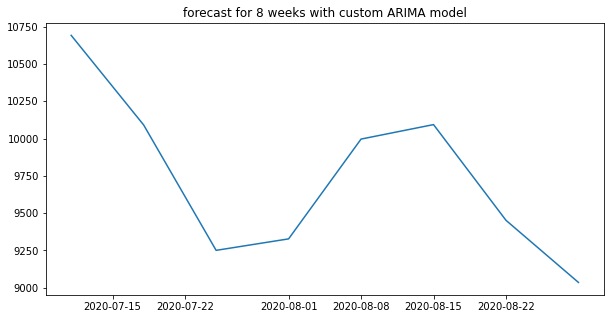

In [27]:
plt.figure(figsize =  (10,5))
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast)
plt.title('forecast for 8 weeks with custom ARIMA model')
plt.show()

In [28]:
mape = mean_absolute_percentage_error(actual_data,forecast)
print('MAPE',mape)
wmape = WMAPE(actual_data,forecast)
print('WMAPE',wmape)

MAPE 37.575722191775625
WMAPE 264.0828056254927


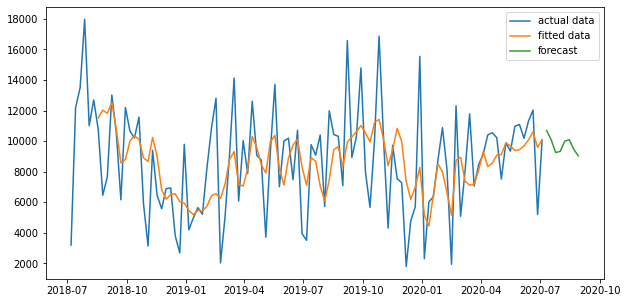

In [29]:
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'actual data')
plt.plot(pd.date_range('2018-08-18',periods = 99, freq = 'W-SAT'),sum(a,b[0,6:]).reshape(-1,1), label = 'fitted data')
plt.plot(pd.date_range('2020-07-11',periods = 8, freq = 'W-SAT'),forecast, label = 'forecast')
plt.legend()
plt.show()

## Using HoltsWinter Model

In [30]:
from statsmodels.tsa.holtwinters import Holt

In [31]:
es_model = Holt(train_df, initialization_method="heuristic")
es_result = es_model.fit()
es_forecast = es_result.forecast(8).rename(r'\alpha=%s'%es_result.model.params['smoothing_level'])


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [32]:
mape = mean_absolute_percentage_error(actual_data,es_forecast)
print('MAPE',mape)
wmape = WMAPE(actual_data,es_forecast)
print('WMAPE',wmape)

MAPE 37.03268308245827
WMAPE 264.0828056254927


In [33]:
es_forecast

2020-07-11    9569.819226
2020-07-18    9578.808052
2020-07-25    9587.796878
2020-08-01    9596.785704
2020-08-08    9605.774530
2020-08-15    9614.763356
2020-08-22    9623.752182
2020-08-29    9632.741008
Freq: W-SAT, Name: \alpha=0.12285714285714286, dtype: float64

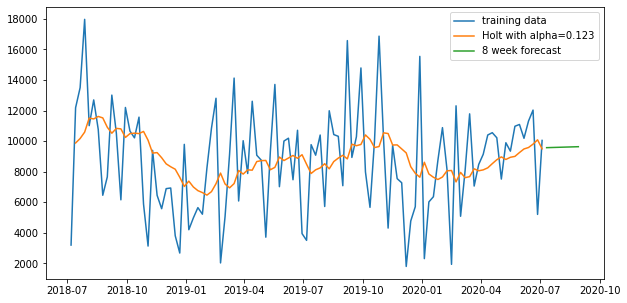

In [34]:
plt.figure(figsize = (10,5))
plt.plot(train_df['Weekly Demand Quantity'], label = 'training data')
plt.plot(es_result.predict(1), label = 'Holt with' + r' alpha=%.3f'%es_result.model.params['smoothing_level'])
plt.plot(es_forecast, label = '8 week forecast')
plt.legend()
plt.show()